In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_egret =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'egret' in i]
train_oystercatcher =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'oystercatcher' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
#train_images = train_dogs[:5] + train_cats[:1000]
#random.shuffle(train_images)
#test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 76
Processed 0 of 8
Train shape: (76, 3, 64, 64)
Test shape: (8, 3, 64, 64)


Text(0.5, 1.0, 'Egrets and Oyster catchers')

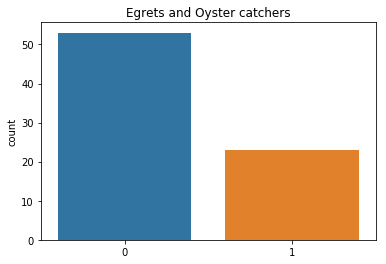

In [3]:
labels = []
for i in train_images:
    if 'egret' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Egrets and Oyster catchers')

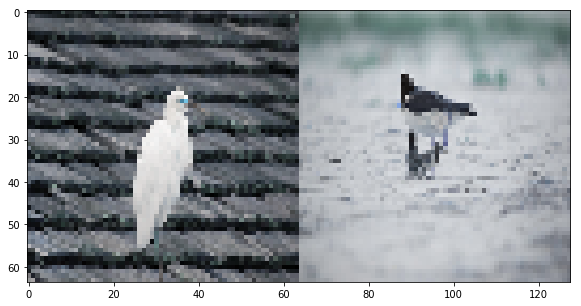

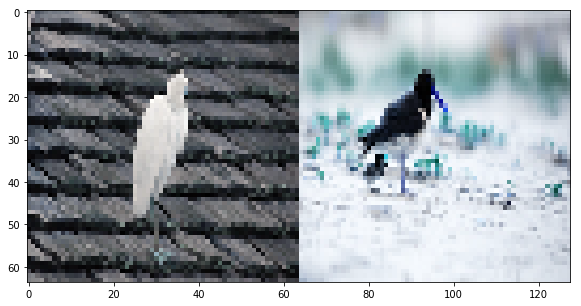

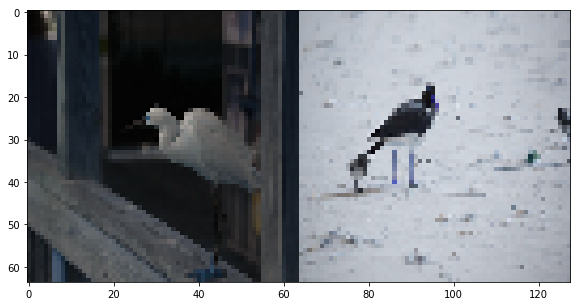

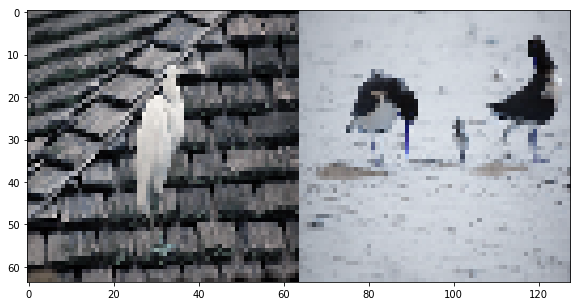

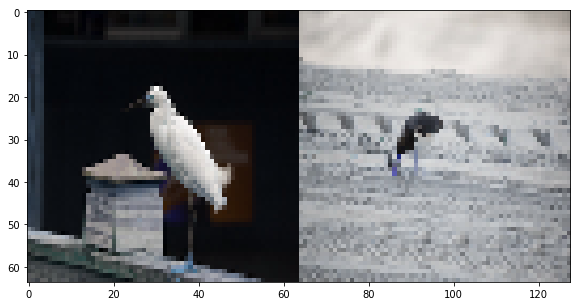

In [5]:
def show_birds(idx):
    egrets = read_image(train_egret[idx])
    oystercatchers = read_image(train_oystercatcher[idx])
    pair = np.concatenate((egrets, oystercatchers), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_birds(idx)

In [6]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def birds_vgg16():
    
    model = Sequential()

    model.add(Convolution2D(64, (3, 3), input_shape=(3, ROWS, COLS), activation='relu', padding='same'))
    model.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

    model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))
    
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))
    
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = birds_vgg16()

In [9]:
epochs = 20
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])
    

    predictions = model.predict(test, verbose=1)
    return predictions, history

predictions, history = run_catdog()

Instructions for updating:
Use tf.cast instead.
Train on 57 samples, validate on 19 samples
Epoch 1/20
57/57 [==============================] - 3s 51ms/step - loss: 3.1367 - acc: 0.5439 - val_loss: 0.9337 - val_acc: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 1s 22ms/step - loss: 0.7215 - acc: 0.4912 - val_loss: 0.4275 - val_acc: 1.0000
Epoch 3/20
57/57 [==============================] - 1s 22ms/step - loss: 0.6656 - acc: 0.5965 - val_loss: 0.7305 - val_acc: 0.0000e+00
Epoch 4/20
57/57 [==============================] - 1s 23ms/step - loss: 0.6830 - acc: 0.4561 - val_loss: 0.5142 - val_acc: 1.0000
Epoch 5/20
57/57 [==============================] - 1s 22ms/step - loss: 0.6225 - acc: 0.5965 - val_loss: 0.5984 - val_acc: 1.0000
Epoch 6/20
57/57 [==============================] - 1s 22ms/step - loss: 0.6912 - acc: 0.5965 - val_loss: 0.6496 - val_acc: 1.0000
Epoch 7/20
57/57 [==============================] - 1s 22ms/step - loss: 0.6502 - acc: 0.5965 - val_loss: 0.3997 -

In [1]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

NameError: name 'history' is not defined

I am 54.84% sure this is a Egret


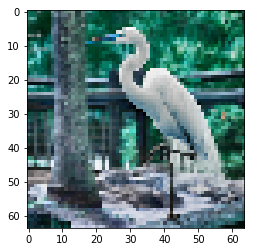

I am 57.16% sure this is a Egret


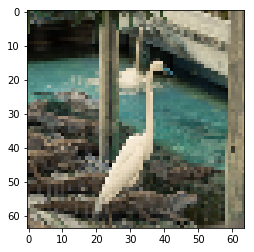

I am 55.33% sure this is a Egret


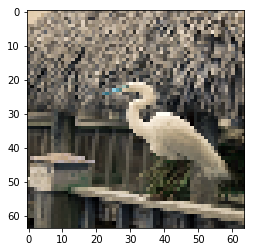

I am 55.72% sure this is a Egret


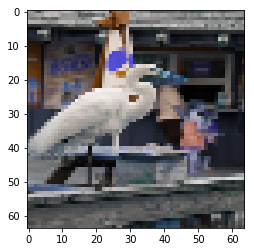

I am 56.40% sure this is a Egret


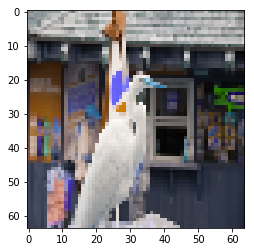

I am 94.26% sure this is a Oyster Catcher


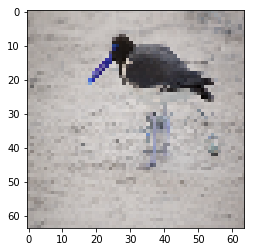

I am 98.08% sure this is a Oyster Catcher


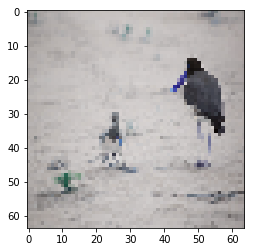

I am 97.77% sure this is a Oyster Catcher


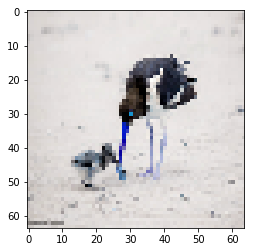

IndexError: index 8 is out of bounds for axis 0 with size 8

In [12]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Egret'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Oyster Catcher'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()